#  AI 보안
- 제공된 LeNet-5 모델 또는 코드를 수정해 CIFAR-10 데이터셋에서 테스트 정확도를 높이는 것을 목표로 함
- 모델 구조 수정 및 다른 학습 기법을 자유롭게 적용
- 재구성된 모델의 정확도가 기준 정확도(46.94%)를 넘을 경우 점수 부여

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 개요
 기존에서 제공된 코드인 LeNet5의 구조조 한계를 극복하기 위해, 다양한 모델링을 적용하여 성능을 개선하고 정확도를 90%이상 달성하는게 목적입니다

Resnet을 사용하여 구조를 개선하였고 이를 통하여 정확도 90퍼 달성하는것이 목적입니다.

# CIFAR-10 정의
- CIFAR-1O 데이터 셋을 로드하고, 학습 및 테스트용으로 변환을 수행한 뒤, 데이터 로더(DataLoader)를 반환하는 역할을 한다.
- CIFAR-10은 10개의 클래스로 이루어진 이미지 분류 데이터 셋, 각각의 이미지의 크기는 32 * 32 픽셀로 구성되어있다.

In [ ]:
# 데이터셋 로드 함수 정의
def load_CIFAR10(root_dataset, batch_size, width=32, height=32):
     # 이미지에 대한 변환 작업 정의
    image_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), # 랜덤 크롭 후 패딩 추가
        transforms.RandomHorizontalFlip(),  # 랜덤으로 수평 뒤집기
        transforms.Resize((width, height)),  # 지정된 크기로 이미지 리사이즈
        transforms.ToTensor(),   # 이미지를 Tensor 형태로 변환
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # 데이터 정규화 - 채널 평균과 표준 편차로 정규화
    ])

    # 테스트 데이터 변환 파이프라인 정의
    test_transform = transforms.Compose([
        transforms.Resize((width, height)), # 지정된 크기로 이미지 리사이주
        transforms.ToTensor(),  # 이미지를 Tensor 형태로 변환
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # 데이터 정규화 - 채널 평균과 표준 편차로 정규화
    ])

    # CIFAR-10 훈련 데이터셋  및 테스트 데이터셋 로드
    train_cifar10 = datasets.CIFAR10(root=root_dataset, train=True, download=True, transform=image_transform)
    test_cifar10 = datasets.CIFAR10(root=root_dataset, train=False, download=True, transform=test_transform)

    # 훈련 데이터 로더 및 테스트 데이터 로 생성
    train_cifar10_loader = DataLoader(dataset=train_cifar10, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_cifar10_loader = DataLoader(dataset=test_cifar10, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

     # 클래스 수 계산
    nb_classes_cifar10 = len(test_cifar10.classes)

    # 데이터 수 및 클래스 수 출력
    print(f'\nNumber of Train Data\t: {len(train_cifar10_loader.dataset)}')
    print(f'Number of Test Data\t: {len(test_cifar10_loader.dataset)}')
    print(f'Number of Classes\t: {nb_classes_cifar10}')

     # 훈련 및 테스트 데이터 로더와 클래스 수 반환
    return train_cifar10_loader, test_cifar10_loader, nb_classes_cifar10

# GPU 사용

- 딥러닝 모델을 효율적으로 학습하기 위해, 사용 가능한 장치를 자동으로 설정 및 데이터를 쉽게 이동하도록 정의함.

- 데이터 로더를 래핑하여 GPU로의 데이터 전송을 간소화 하며, 학습과정에서 성능을 향상시킴.

In [ ]:
# GPU 설정 함수
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # 사용할 수 있는 GPU가 있으면 CUDA 장치를 반환하고, 그렇지 않으면 CPU를 반환

# 입력 데이터가 리스트나 튜플인 경우, 각각의 요소를 재귀적으로 to_device 호출
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)  # 데이터 텐서를 지정된 장치로 이동 (비차단 모드)

  # 데이터 로더(dl)와 이동할 장치(device) 저장
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

 # 데이터 로더에서 배치별로 데이터를 가져와서 지정된 장치로 전송
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

  # 데이터 로더의 길이 반환 (전체 배치 수)
    def __len__(self):
        return len(self.dl)

# ResNet 모델(Residual Network)
- 기울기 소실(Gradient Vanishing) 문제를 해결하기 위해 개발된 모델, 잔차 연결(Residual Connection)을 통해서 shortcut 연결을 추가하는 방식으로 학습 성능을 유지하거나 개선하는게 목적.
-잔차 블록 때문에, 단순한 9, 18 Layer가 아니라 50, 101, 152Layer 등 더 깊은 신경망을 사용해도 성능이 더 개선될 수 있음.
-즉, Resnet는 네트워크가 깊더라도 기울기 소실(Gradient Vanishing) 문제를 해결하거나 완화시켜주며, 네트워크 깊이를 더 확장해서 복잡한 데이터에서도 좋은 성능을 낼 수 있게 해줌.
- 하지만 잔차블록은 보통 컨볼루션 레이어 2개이상 쌓아서 구성됨
-밑에 코드는 직접적으로 잔차블록을 사용하지 않고 시퀀스 연결로 구성하여 만듬

In [ ]:
# Conv Block 정의
def conv_block(in_channels, out_channels, pool=False):
     # 주어진 입력 채널 수와 출력 채널 수를 사용하여 컨볼루션 블록 생성
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # 3x3 컨볼루션
              nn.BatchNorm2d(out_channels), # 배치 정규화
              nn.ReLU(inplace=True)] #  ReLU 활성화 함수
    if pool: # 풀링이 필요한 경우
        layers.append(nn.MaxPool2d(2)) # 2x2 맥스 풀링 추가
    return nn.Sequential(*layers) # 레이어를 순차적으로 연결하여 반환

# ResNet9 모델 정의
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__() # 부모 클래스 초기화
        self.conv1 = conv_block(in_channels, 64)  # 첫 번째 컨볼루션 블록
        self.conv2 = conv_block(64, 128, pool=True) # 두 번째 컨볼루션 블록 (풀링 포함)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))  # 첫 번째 잔차 블록
        self.conv3 = conv_block(128, 256, pool=True) # 세 번째 컨볼루션 블록 (풀링 포함)
        self.conv4 = conv_block(256, 512, pool=True) # 네 번째 컨볼루션 블록 (풀링 포함)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 두 번째 잔차 블록
        self.classifier = nn.Sequential(nn.MaxPool2d(4),   # 4x4 맥스 풀링
                                        nn.Flatten(), # 텐서를 1차원으로 변환
                                        nn.Linear(512, num_classes)) # 최종 선형 계층

    # Forward 함수 정의
    def forward(self, xb):
        out = self.conv1(xb)  # 첫 번째 컨볼루션 블록을 통과
        out = self.conv2(out)  # 두 번째 컨볼루션 블록을 통과
        out = self.res1(out) + out  # 첫 번째 잔차 블록을 통과하고 skip connection 추가
        out = self.conv3(out)  # 세 번째 컨볼루션 블록을 통과
        out = self.conv4(out)  # 네 번째 컨볼루션 블록을 통과
        out = self.res2(out) + out  # 두 번째 잔차 블록을 통과하고 skip connection 추가
        out = self.classifier(out)  # 분류기 통과
        return out  # 출력 반환

    # 훈련 단계, 각 배치에 대한 손실을 계산하는 함수
    def training_step(self, batch):
        images, labels = batch  # 배치에서 이미지와 레이블 추출
        out = self(images)  # 모델에서 예측값을 생성
        loss = F.cross_entropy(out, labels)  # 손실 계산 (크로스 엔트로피)
        return loss  # 손실 반환

    # 검증 단계. 각 배치에 대한 손실과 정확도를 계산하는 함수
    def validation_step(self, batch):
        images, labels = batch  # 배치에서 이미지와 레이블 추출
        out = self(images)  # 모델에서 예측값을 생성
        loss = F.cross_entropy(out, labels)  # 손실 계산 (크로스 엔트로피)
        acc = accuracy(out, labels)  # 정확도 계산
        return {'val_loss': loss.detach(), 'val_acc': acc}  # 손실과 정확도를 딕셔너리 형태로 반환

    # 검증 단계의 모든 배치에 대한 결과를 집계, 에폭의 손실과 정확도를 계산하는 함수.
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]  # 각 배치의 손실을 추출
        epoch_loss = torch.stack(batch_losses).mean()  # 에포크 손실의 평균 계산
        batch_accs = [x['val_acc'] for x in outputs]  # 각 배치의 정확도를 추출
        epoch_acc = torch.stack(batch_accs).mean()  # 에포크 정확도의 평균 계산
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}  # 평균 손실과 정확도를 반환

In [ ]:
# 학습률 스케줄러 및 옵티마이저 정의
#파라미터에 대해 Adam 옵티마이저를 생성하고, max_lr를 학습률로 설정
def get_optimizer(model, max_lr):
    return torch.optim.Adam(model.parameters(), max_lr)


In [ ]:
# 손실 및 정확도 계산 함수
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)  # 모델의 출력에서 예측된 클래스의 인덱스를 가져옴
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)) # preds와 labels를 비교 및 정확도 계산, 서로 같은 경우의 수를 세고, 전체 예측 수로 나누어 정확도를 구함.


In [ ]:
# 모델 평가
def evaluate(model, val_loader):
    model.eval() # 모델을 평가 모드로 전환.
    outputs = [model.validation_step(batch) for batch in val_loader] # 검증 데이터 로더를 통해 배치별로 검증 단계를 수행하고 결과를 저장.
    return model.validation_epoch_end(outputs)  # validation_epoch_end함수 호출, 에포크의 결과를 종합적으로 계산.

# 모델 학습 및 검증 과정 정의

- 모델을 주어진 데이터로 학습하고 검증하는 코드
- One Cycle 학습 방법을 통해 모델 학습 및 검증을 하며
ResNet9 모델에 대한 훈련 및 검증 프로세스

In [ ]:
# 주어진 에폭 수 만큼 모델을 학습하고 검증.
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, grad_clip=None):
    torch.cuda.empty_cache() # GPU 메모리 캐시를 비워서 메모리 확보
    optimizer = get_optimizer(model, max_lr) # 옵티마이저 정의
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))  # OneCycleLR 스케줄러 정의

    history = []  # 에포크 결과를 저장할 리스트 초기화
    for epoch in range(epochs):
        model.train()  # 모델을 훈련 모드로 설정
        train_losses = []  # 훈련 손실을 저장할 리스트 초기화
        for batch in train_loader:
            loss = model.training_step(batch) # 현재 배치에 대한 손실 계산
            train_losses.append(loss) # 손실 리스트에 추가
            loss.backward()  # 손실에 대한 기울기 계산

            # 기울기 클러핑, 과도한 기울기 폭발을 방지.
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step() # 옵티마이저를 사용하여 가중치 업데이트
            optimizer.zero_grad()  # 기울기를 0으로 초기화
            sched.step()  # 학습률 스케줄러 업데이트

        # 검증 단계
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item() # 평균 훈련 손실 계산

        # 에포크 결과 출력
        print(f'{epoch+1}/{epochs:5d}: Train Loss [{result["train_loss"]:.2f}] / Test Loss [{result["val_loss"]:.2f}], Test Accuracy [{result["val_acc"]*100:.2f}%]')

        history.append(result) # 현재 에포크 결과를 히스토리에 추가

    return history  # 모든 에포크 결과 반환

# 메인 함수

- Cifar 10 데이터셋을 로드 및 모델 학습시키고 검증을 하는 메인함수  

In [ ]:
# 메인 함수
if __name__ == '__main__':
    device = get_default_device()   # 사용할 기본 장치(GPU 또는 CPU) 설정

     # 데이터셋 경로 및 하이퍼파라미터 설정
    root_dataset = './cifar10'  # 데이터셋이 저장될 경로
    batch_size = 400 # 배치 크기 설정
    epochs = 20 # 에포크 수 설정
    max_lr = 0.01 # 최대 학습률 설정


    # CIFAR-10 데이터셋 로드
    train_loader, test_loader, nb_classes = load_CIFAR10(root_dataset, batch_size)

    # 데이터 로더를 지정된 장치로 전송
    train_loader = DeviceDataLoader(train_loader, device)
    test_loader = DeviceDataLoader(test_loader, device)

    # ResNet9 모델을 장치에 맞게 초기화, 3은 입력 클래스
    model = to_device(ResNet9(3, nb_classes), device)

    # 모델 학습 및 검증 실행
    history = fit_one_cycle(epochs, max_lr, model, train_loader, test_loader)

100%|██████████| 170498071/170498071 [00:04<00:00, 41817057.88it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Number of Train Data	: 50000
Number of Test Data	: 10000
Number of Classes	: 10
1/   20: Train Loss [1.31] / Test Loss [1.11], Test Accuracy [60.82%]
2/   20: Train Loss [0.86] / Test Loss [0.91], Test Accuracy [67.84%]
3/   20: Train Loss [0.72] / Test Loss [1.01], Test Accuracy [68.55%]
4/   20: Train Loss [0.64] / Test Loss [0.86], Test Accuracy [72.71%]
5/   20: Train Loss [0.61] / Test Loss [0.66], Test Accuracy [78.98%]
6/   20: Train Loss [0.50] / Test Loss [0.70], Test Accuracy [79.51%]
7/   20: Train Loss [0.42] / Test Loss [0.96], Test Accuracy [75.86%]
8/   20: Train Loss [0.36] / Test Loss [0.43], Test Accuracy [85.89%]
9/   20: Train Loss [0.30] / Test Loss [0.40], Test Accuracy [86.88%]
10/   20: Train Loss [0.26] / Test Loss [0.37], Test Accuracy [88.06%]
11/   20: Train Loss [0.21] / Test Loss [0.36], Test Accuracy [88.68%]
12/   20: Train Loss [0.18] / Test Loss [0.35], Test Accuracy [89.01%]
13/   20: Train Loss [0.14] / Test Loss [0.31], Test Accuracy [90.46%]
14/  

# 시각화 (Visualization)
- 학습 손실과 검증 손실을 시각화
- 정확도 시각화

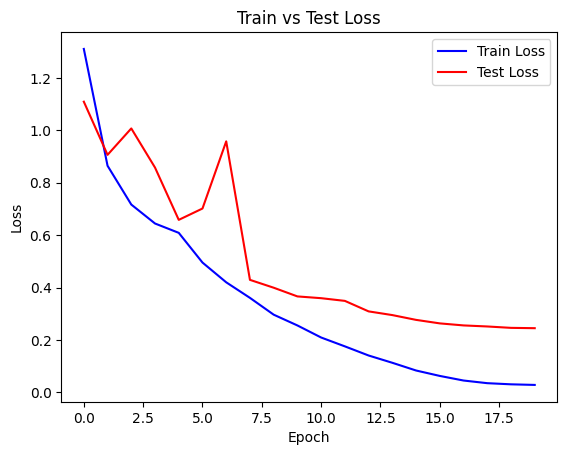

In [ ]:
# 손실 시각화 (Train Loss 및 Test Loss)
train_losses = [x.get('train_loss') for x in history]  # 각 에포크에서의 train_loss
val_losses = [x.get('val_loss') for x in history]  # 각 에포크에서의 val_loss

plt.figure()
plt.title('Train vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Test Loss', color='red')
plt.legend()
plt.show()


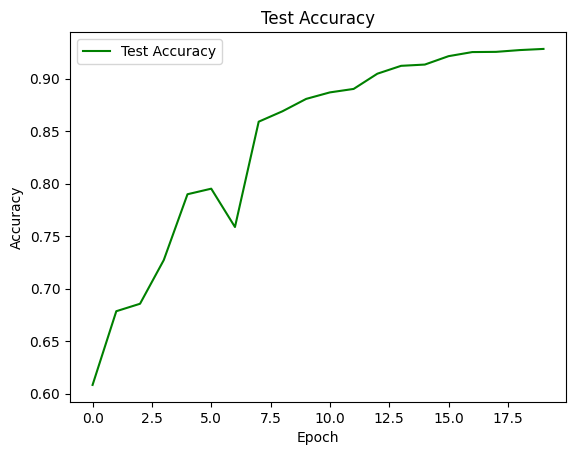

In [ ]:
# 정확도 시각화 (Test Accuracy)
val_accuracies = [x.get('val_acc') for x in history]  # 각 에포크에서의 val_acc

plt.figure()
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(val_accuracies, label='Test Accuracy', color='green')
plt.legend()
plt.show()